# 一、随机 lsb 隐写实现

### 随机 lsb 隐写过程
1. 生成随机数列，作为嵌入步长，对满足嵌入步长的字节末位进行比特替换。
    此处随机序列生成有多种选择：
    - 修改文件时 unix 时间（取转换时时间的十进制千位及以上数字作为随机种子）
    - 以正常照片的某一项 metadata（如 geolocation ）作为种子，但往往有此特征的图片都是由真实相机拍摄的 jpg 格式图片，jpg 有损压缩的特性决定不能用于 lsb 隐写
    - 以上述数据混合后的约定加盐 hash 作为种子
    但考虑到上述数据具有易于毁坏的特性，往往可以被修改覆盖掉而不影响图片的阅览，于是考虑使用图片像素的 msb 序列的 md5 做为随机列生成函数

In [1]:
%config IPCompleter.greedy=True
import cv2
import numpy as np
from random import Random
from hashlib import md5
import os

In [2]:
def digest_rand(a:np.ndarray, count, rand_range=(1, 5)):
    assert all(i > 0 for i in rand_range), "rand_range can't be zero or negative"
    gen = Random(md5((a>>7).tobytes()).digest())
    return np.array([gen.randint(*rand_range) for _ in range(count)])

In [3]:
def embed(string, img, output_file="output.png", rand_range=(1, 5)):
    """Embed string inside the last lsb_plane of specific image and dump it to output_file.\n
            (input string can be bytes type)"""
    cover = cv2.imread(img)
    cover_array = cover.ravel()
    sparse = [len(string) >> j & 1 for j in range(32)] # 前 32 位用于存储字节数
    for i in string:
        if type(string) == str:
            sparse += [(ord(i) >> j) & 1 for j in range(8)]
        elif type(string) == bytes:
            sparse += [(i >> j) & 1 for j in range(8)]
    sparse = np.array(sparse, dtype=np.uint8)
    rand_array = digest_rand(cover_array, sparse.size - 32, rand_range)

    print("cover image bytes: ", cover.size)
    print("sparsed info bytes: ", sparse.size)
    assumed_len = sum(rand_array)
    print("assumed length: ", assumed_len)
    if cover.size < assumed_len:
        print("img size too small, you may try to limit the rand_range to compress the gap.")
        return 1
    
    selector = np.empty(cover.size, dtype=np.bool)
    selector[:] = False; selector[:32] = True
    selector[np.cumsum(rand_array)+31] = True
    
    cover_array[selector] = (cover_array[selector] >> 1) << 1
    cover_array[selector] += sparse
    cv2.imwrite(output_file, cover_array.reshape(cover.shape))

- 尝试隐写

In [4]:
embed("flag{35caqe_chi_z9u4r3_w1th_3n7ropy}", "lena.png", output_file="flag.png")

cover image bytes:  786432
sparsed info bytes:  320
assumed length:  844


In [5]:
def extract(img="output.png", dump_file=None, binary=False, rand_range=(1, 5)):
    """Extract info from lowest lsb plane of img, set binary flag to specify file type, dump_file to save binary data"""
    crypt = cv2.imread(img).ravel()
    bit_flat = crypt & np.ones(crypt.size, dtype=np.uint8)
    length = sum([bit_flat[i] << i for i in range(32)])
    if length > bit_flat.size:
        print("Incredible size.")
        return 
    
    rand_array = digest_rand(crypt, length*8, rand_range)
    selector = np.empty(crypt.size, dtype=np.bool)
    selector[:] = False; selector[:32] = True
    selector[np.cumsum(rand_array)+31] = True
    bit_flat = bit_flat[selector]
    
    info = np.array(bit_flat[32: 32+8*length]).reshape(length, 8)
    msg = bytes() if binary else ""
    for i in info:
        if binary:
            msg += bytes([sum([i[j] << j for j in range(8)])]) #小心 bytes 构建函数的用法
        else:
            msg += chr(sum([i[j] << j for j in range(8)]))
            
    if dump_file:
        if binary:
            with open(dump_file, "wb") as f:
                f.write(msg)
        else:
            with open(dump_file, "w") as f:
                f.write(msg)
    else:
        return msg
    

- 尝试提取（提取时的随机数范围必与隐藏时一致）

In [6]:
extract("flag.png")

'flag{35caqe_chi_z9u4r3_w1th_3n7ropy}'

- 隐藏文件

In [7]:
with open("keygen2032.rar", "rb") as f:
    content = f.read()
    embed(content, "lena.png", rand_range=(1,5))
    print("content length: ", len(content))

cover image bytes:  786432
sparsed info bytes:  186568
assumed length:  560500
content length:  23317


- 提取文件并校验

In [8]:
extract(dump_file="result2.rar", binary=True)
with open("keygen2032.rar","rb") as f1, open("result2.rar", "rb") as f2:
    print(hash(f1.read()) == hash(f2.read()))

True


### 卡方检验测试

In [9]:
from matplotlib import pyplot as plt
from scipy import stats

In [10]:
def analyse(embedded_img="output.png", sample_size=10000, draw=True, lsb_plane=1):
    """chi square analyse specified with step of sample size"""
#     raw_img = cv2.imread(raw_img)
    embedded_img = cv2.imread(embedded_img)
    embedded_img = embedded_img.ravel() >> (lsb_plane - 1)
    X, Y =[], []
    for i in range(sample_size, len(embedded_img), sample_size):  #连续 lsb 隐写检验
        stat = np.bincount(embedded_img[i-sample_size:i], minlength=256)
        mask = (stat[::2]+stat[1::2])/2 != 0   #过滤0值
        res = stats.chisquare(f_obs=stat[::2][mask], f_exp=((stat[::2]+stat[1::2])/2)[mask])
        X.append((i-sample_size/2)/len(embedded_img))
        Y.append(res.pvalue)
    if draw:
        plt.figure(dpi=100)
        plt.ylim(-0.01,1.01)
        plt.title("$\chi^2$ test")
        plt.ylabel(f"probability per {sample_size} sample")
        plt.plot(X, Y, 'r-', label=f"probability per {sample_size} sample")
        plt.show()
    return Y

In [11]:
def random_embed(proportion, imgfile="sample.png", rand_range=(1,5)):
    length = cv2.imread(imgfile).size
    embed(np.random.bytes((length - 32) * proportion / 8), imgfile, output_file="rand.png", rand_range=rand_range)

cover image bytes:  1829898
sparsed info bytes:  183016
assumed length:  1372652


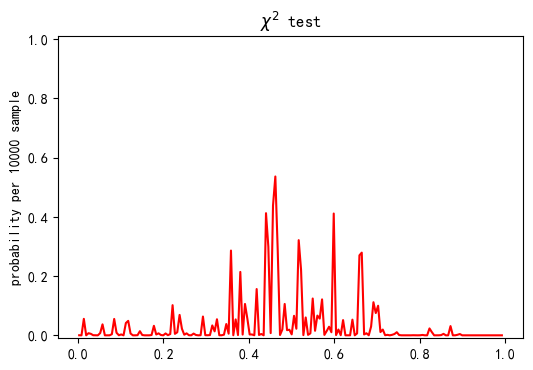

cover image bytes:  1829898
sparsed info bytes:  271088
assumed length:  1762207


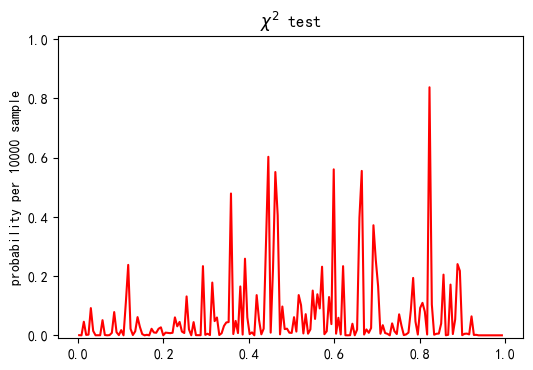

In [17]:
random_embed(0.1, "eniac.png", (5,10))
analyse(embedded_img="rand.png",sample_size=10000);
# os.remove("rand.png")
with open("lorem lpsum.txt") as f:
    embed(f.read(), "eniac.png", output_file="lorem.png", rand_range=(5,8))
analyse("lorem.png");

事实上，当两隐写数据随机间隔范围比较小时（如本例中范围为(5,10)），数据往往呈现多峰状况，如图中所示。

# 二、RS 检测

1. 基于预设的M，计算待检测图像中如下统计量：$R_M(p/2)$、$S_M(p/2)$ 、$R_{-M}(p/2)$ 和 $S_{-M}(p/2)$；
2. 将图像所有像素的最低有效位进行翻转，计算统计量：$R_M(1-p/2)$、$S_M(1-p/2)$ 、$R_{-M}(1-p/2)$ 和 $S_{-M}(1-p/2)$；
3. 根据式(3)解方程可得绝对值较小的根，即为z值；
4. 根据 p=z/(z-1/2) 得到嵌入信息比率的估计值。

发现掩膜 M 不能全为 1 或全为 -1，会导致二次项 a 为 0.

In [22]:
from pdb import set_trace
# RS 检测特定函数
f = lambda x: np.abs(x[:-1] - x[1:]).sum() # 平滑度函数
F_1 = lambda x, m: np.where(m, x+1 - 2 * (x & 0b1), x)  # 正翻转
F_N1 = lambda x, m: np.where(m, x-1 + 2 * (x & 0b1), x)  # 负翻转

def rs_check(img, split=(20, 20), mask=None, TFrate=[0.5, 0.5]):
    img = cv2.imread(img)
    dim = (img.shape[0] // split[0], img.shape[1] // split[1])
    if not mask:
        mask = np.random.choice([True, False], size=split[0] * split[1], p=TFrate)
    trunks = []
    for i in range(3):   # 彩色 png 图像 3 个色彩平面
        for j in range(dim[0]):
            for k in range(dim[1]):
                trunks.append(img[j*split[0]:(j+1)*split[0],k*split[1]:(k+1)*split[1],i].ravel())
    
    regular = list(map(lambda x: f(F_1(x, mask)) > f(x), trunks))
    singular = list(map(lambda x: f(F_1(x, mask)) < f(x), trunks))
    R_M = sum(regular) / len(regular)
    S_M = sum(singular) / len(singular)
    regular = list(map(lambda x: f(F_N1(x, mask)) > f(x), trunks))
    singular = list(map(lambda x: f(F_N1(x, mask)) < f(x), trunks))
    R_NM = sum(regular) / len(regular)
    S_NM = sum(singular) / len(singular)
    
    regular = list(map(lambda x: f(F_1(x^1, mask)) > f(x^1), trunks))
    singular = list(map(lambda x: f(F_1(x^1, mask)) < f(x^1), trunks))
    R_M_ = sum(regular) / len(regular)
    S_M_ = sum(singular) / len(singular)
    regular = list(map(lambda x: f(F_N1(x^1, mask)) > f(x^1), trunks))
    singular = list(map(lambda x: f(F_N1(x^1, mask)) < f(x^1), trunks))
    R_NM_ = sum(regular) / len(regular)
    S_NM_ = sum(singular) / len(singular)
    
    d_0 = R_M - S_M
    d_N0 = R_NM - S_NM
    d_1 = R_M_ - S_M_
    d_N1 = R_NM_ - S_NM_
    
    A = 2*(d_1 + d_0); B = (d_N0 - d_N1 - d_1 -3*d_0); C = d_0 - d_N0
    z_1 = (-B - np.sqrt(B**2 - 4*A*C)) / (2*A)
    z_2 = (-B + np.sqrt(B**2 - 4*A*C)) / (2*A)
    print(z_1, z_2)
    return z_1/(z_1-1/2), z_2/(z_2-1/2)

In [30]:
rs_check("lorem.png", split=(2,2))

-0.05661076672623581 1.678855945789597


(0.10170620137155796, 1.42414003321254)

注意到，这里的 RS 检测函数没有准确的返回值，每次运行结果是不一样的，且概率有可能出现负值。但是经过检验每一步是按照说明进行运算的。算法中有一些细节没有明确，比如分块的大小、 mask 向量中中的0和1 的个数（应该有多少像素做正/负反转，多少像素不变）没有确定。在查询中得到的网络建议是选择 2x2 分块，选择 \[0，1，1，0\] 作为 mask 进行运算，但也不尽如人意，结果随隐写内容的不确定因素变化很大。暂时没有找到好的解决办法。

图像平滑性是 RS 检测的关键指标，如果能够在隐写时尽量保证图像的平滑性，则可能绕过 RS 检测。